# Dynex' Q-Score

Q-score measures the efficiency of running a representative quantum application, a system's effectiveness at handling real-life problems, instead of its theoretical or physical performance. [1]. The Q-Score calculation for the Dynex Neuromorphic Computing platform is based by Atos' official package for measuring the Q-Score [2]

In "Evaluating the Q-score of Quantum Annealers", Ward van der Schoot et al calculated the Q-Score for a series of D-Wave quantum devices, classical algorithms and hybrid quantum-classical systems. The public Q-Score package [2] has been used to generate the Q-Score for the Dynex Neuromorphic Computing Platform.

In [2]:
import dynex
import dimod
from pyqubo import Array

### Dynex SDK Version used

In [3]:
dynex.__version__

'0.1.9'

In [4]:
import networkx as nx
from collections import defaultdict
import numpy as np
from datetime import datetime
import pickle
from dimod import BinaryQuadraticModel, BINARY
from tqdm.notebook import tqdm

## Atos Q-Score Package

In [5]:
def draw_sampleset(G, sampleset):
    """
    Function to draw graph 'G' by applying 'sampleset'
    """
    lut = sampleset.first.sample

    # Interpret best result in terms of nodes and edges
    S0 = [node for node in G.nodes if not lut[node]]
    S1 = [node for node in G.nodes if lut[node]]
    cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
    uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

    # Display best result
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
    nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
    nx.draw_networkx_labels(G, pos)

In [16]:
def run_job(size, depth = 1, seed=None, plot=False, strength = 10, generate_random = False, debug = False):
    """
    (Re)Implementation of Ato's generate_maxcut_job() function as specified in job_generation.py. It
    generates a randum Erdos-Enyi graph of a given size, converts the graph to a QUBO formulation and
    returns the two sets as well as the number of cuts (= energy ground state) to be consistent with the paper
    
    Parameters:
    -----------
    - size (int): size of the maximum cut problem graph
    - depth (int): depth of the problem
    - seed (int): random seed
    - plot (boolean): plot graphs 
    - strength (int): weight of qubo formulations' edges
    - generate_random (boolean): implementation of a random assignment, can replace 0.178 * pow(size, 3 / 2) from paper 
    
    Returns:
    --------
    - Set 0 (list)
    - Set 1 (list)
    - maximum_cut result (int)
    - random_cut result (int)
    """
    # Create a Erdos-Renyi graph of a given size:
    G = nx.generators.erdos_renyi_graph(size, 0.5, seed=seed);
    if debug:
        print('Graph generated. Now constructing Binary Quadratic Model...')
    if plot:
        nx.draw(G);
    
    # Convert graph to Qubo 
    #Q = defaultdict(int)
    # Update Q matrix for every edge in the graph
    #for i, j in G.edges:
    #    Q[(i,i)]+= -1 * strength;
    #    Q[(j,j)]+= -1 * strength;
    #    Q[(i,j)]+=  2 * strength;
    #bqm = dimod.BinaryQuadraticModel.from_qubo(Q, 0.0);
    
    # we directly build a binary quadratic model (faster):
    _bqm = BinaryQuadraticModel.empty(vartype=BINARY);
    for i, j in tqdm(G.edges):
        _bqm.add_linear(i, -1 * strength);
        _bqm.add_linear(j, -1 * strength);
        _bqm.add_quadratic(i,j, 2 * strength);
        
    if debug:
        print('BQM generated. Starting sampling...');
    
    # Sample on Dynex Platform:
    model = dynex.BQM(_bqm, logging=False);
    sampler = dynex.DynexSampler(model, mainnet=False, description='Dynex SDK test', logging=False);
    sampleset = sampler.sample(num_reads=500000, annealing_time = 300, debugging=False);
    cut = (sampleset.first.energy * -1 ) / strength;
    print('Ground state cut = ',cut);
    
    # Random cut?
    r_cut = -1;
    if generate_random:
        random_assignment = list(np.random.randint(0, 2, size))
        r_assignment = dimod.SampleSet.from_samples_bqm(random_assignment, _bqm)
        r_cut = (r_assignment.first.energy * -1 ) / strength;
    
    if plot:
        draw_sampleset(G, sampleset)
    
    return cut, r_cut
    

In [17]:
_NB_INSTANCES_PER_SIZE = 5 #100
_INITIAL_SIZE = 5
_DEFAULT_SIZE_LIMIT = 20
_DEFAULT_DEPTH = 1
_DEFAULT_OUT_FILE = "out.csv"
_DEFAULT_RAW_FILE = "out.raw"
beta = 0.2
seed = 1234

In [9]:
_INTRO = """=== Running Q-score benchmark | {date} ===
Instances size:    {init_size} -- {final_size}
Beta:              {beta}
Ansatz depth:      {depth}
Output file:       {output}
Raw output file:   {rawdata}
Random seed:       {seed}
================================="""

_HEADER = """# Q-Score run | {date}
# Instances size:    {init_size} -- {final_size}
# Ansatz depth:      {depth}
# Beta:              {beta}
# Output file:       {output}
# Raw output file:   {rawdata}
# Random seed:       {seed}
# size, avg. score, avg. random score
"""

In [18]:
def _exhaustive(start_size, end_size):
    """
    Iterates over all the values of the domain until it finds a negative value.
    """
    values = dict()
    for index in range(start_size, end_size + 1, 10):
        value = yield index
        values[index] = value
        if value < 0:
            if index == start_size:
                return False, value, (False, start_size)
            return True, values, index - 1
    return False, values, (True, max(values), values[max(values)])


def _dichotomic(start_size, end_size):
    """"""
    lower = start_size
    upper = end_size
    value = yield lower
    values = dict()
    values[lower] = value
    value = yield upper
    values[upper] = value

    if values[upper] > 0:
        return False, values, (True, max(values), values[max(values)])
    if values[lower] < 0:
        return False, value, (False, start_size)
    while True:
        if abs(upper - lower) <= 1:
            return True, values, lower
        next_index = (upper + lower) // 2
        values[next_index] = yield next_index
        if values[next_index] < 0:
            upper = next_index
        else:
            lower = next_index


GENERATORS = {"exhaustive": _exhaustive, "dichotomic": _dichotomic}

In [19]:
class Driver:
    """
    Drives the interaction with an iterator.

    Arguments:
        fun(callable): the evaluation function.
          It should take an index and return a score.
        iteration(str): either "exhaustive" or "dichotomic"
        start_size(int): the start size (i.e the lowest index)
        end_size(int): the end size (i.e the highest index)
    """

    def __init__(self, fun, iteration, start_size, end_size):
        if iteration not in GENERATORS:
            raise ValueError(f"Unknown iteration method {iteration}")
        self.generator = GENERATORS[iteration](start_size, end_size)
        self.fun = fun

    def run(self):
        """
        Runs the iteration and returns a tuple containing:
        - the success status (True, if an index exists such that f(index) > 0 and f(index + 1) <= 0, False otherwise)
        - a map<index, value> containing all the evaluated point
        - if found, the index such that f(index) > 0 and f(index + 1) <= 0
        """
        index = next(self.generator)
        while True:
            try:
                index = self.generator.send(self.fun(index))
            except StopIteration as exp:
                return exp.value

In [20]:
class QScore:
    # pylint: disable=too-many-instance-attributes
    """

    Arguments:
        qpu(:class:`~qat.core.qpu.QPUHandler`): the QPU to benchmark (including its compilation stack).
          The QPU should support variational optimization.
        initial_size(int, optional): the initial instance size to try. Default to 5.
        size_limit(int, optional): a limit on the size of MAX-CUT instances to try to solve.
          Instance sizes will vary from 5 to this limit. Default to 20.
        beta(float, optional): the threshold ratio for the test. The official test uses
          20% (0.2) as threshold. Default to 0.2
        iterator(str, optional): the iteration method to use ("exhaustive" or "dichotomic").
          Default to "dichotomic".
        depth(int, optional): the QAOA depth to use. Default to 1.
        output(str, optional): a file name to store the benchmark output (in CSV format).
          Default to out.csv.
        rawdata(str, optional): a file name in which to store the raw output of all the runs
          performed during the benchmark. Default to out.raw.
        seed(int, optional): a seed for the instances generation
    """

    def __init__(
        self,
        qpu,
        size_limit=_DEFAULT_SIZE_LIMIT,
        initial_size=_INITIAL_SIZE,
        beta=0.2,
        iterator= "exhaustive", # "dichotomic",
        depth=_DEFAULT_DEPTH,
        output=_DEFAULT_OUT_FILE,
        rawdata=_DEFAULT_RAW_FILE,
        seed=None,
    ):
        self._executor = qpu
        self._size_limit = size_limit
        self._iterator = iterator
        self._initial_size = initial_size
        self._depth = depth
        self._output = output
        self._rawdata = rawdata
        self._seed = seed if seed is not None else np.random.randint(100000)
        self._beta = beta

    def run(self):
        """
        Runs the benchmark.
        """
        date_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        print(
            _INTRO.format(
                date=date_string,
                init_size=self._initial_size,
                final_size=self._size_limit,
                beta=self._beta,
                depth=self._depth,
                output=self._output,
                rawdata=self._rawdata,
                seed=self._seed,
            )
        )
        all_data = {}
        seed = self._seed
        to_output = _HEADER.format(
            date=date_string,
            init_size=self._initial_size,
            beta=self._beta,
            final_size=self._size_limit,
            depth=self._depth,
            output=self._output,
            rawdata=self._rawdata,
            seed=self._seed,
        )

        def _evaluate_point(size, seed=seed, to_output=to_output, self=self):
            """
            Function that evaluates a single point.
            """
            print(f"Running for n={size:2d}.", end=" ", flush=True)
            scores = []
            data = []
            for _ in range(_NB_INSTANCES_PER_SIZE):
                
                #job = generate_maxcut_job(size, self._depth, seed=seed)
                #result = self._executor.submit(job)
                #result = -cut; # cut is already positive
                #scores.append(-result.value)
                #data.append({"seed": seed, "score": -result.value})
                #seed += 1
                
                # the above was replaced with Dynex Sampling function run_job:
                cut, r_cut = run_job(size, depth = self._depth, seed=None, plot=False, strength = 1000);
                scores.append(cut);
                data.append({"seed": seed, "score": cut})
                seed += 1
                #print('    cut: ', cut)
                
            average_score = np.mean(scores) - size * (size - 1) / 8
            avg_best_score = 0.178 * pow(size, 3 / 2)
            print(f"Score: {average_score:.2f}.", end=" ")
            print(f"Random best score: {avg_best_score:.2f}.", end="\t")
            to_output = f"{size},{average_score},{avg_best_score}\n"
            all_data[size] = data
            pickle.dump(all_data, open(self._rawdata, "wb"))
            with open(self._output, "a") as fout:
                fout.write(to_output)
            achieved_ratio = average_score / avg_best_score
            if achieved_ratio > self._beta:
                print("Success.", "beta = ",achieved_ratio)
            else:
                print("Fail.", "beta = ", achieved_ratio)
            return achieved_ratio - self._beta

        success, _, info = Driver(_evaluate_point, self._iterator, self._initial_size, self._size_limit).run()
        
        print('   ', info)

        if success:
            print(f"Success. QScore({self._beta}) = {info}")
        else:
            if info[0]:
                print(f"Failure. QScore({self._beta}) > {info[1]}")
                print("Maybe try to increase the max instance size !")
            else:
                print(f"Failure. QScore({self._beta}) < {info[1]}")


# Running Q-Score 

According to the paper, the Q-Score is defined as the size 'N' at which the beta drops below 0.2. To evaluate this, sizes from 5 to x need to iteratively being tried. Results of all runs are stored in "out.csv" which can also be used to plot a chart similar to the ones presented in [1]. The run will return Success for a given value of 'N' until the reached beta falls below the threshold.

In [21]:
QScore(None, size_limit = 180, depth = 1, output = 'out.csv', rawdata = 'out.raw', seed = 1234).run()

=== Running Q-score benchmark | 12/10/2023 07:14:23 ===
Instances size:    5 -- 180
Beta:              0.2
Ansatz depth:      1
Output file:       out.csv
Raw output file:   out.raw
Random seed:       1234
Running for n= 5. 

  0%|          | 0/4 [00:00<?, ?it/s]

Ground state cut =  4.0


  0%|          | 0/7 [00:00<?, ?it/s]

Ground state cut =  4.0


  0%|          | 0/4 [00:00<?, ?it/s]

Ground state cut =  3.0


  0%|          | 0/4 [00:00<?, ?it/s]

Ground state cut =  4.0


  0%|          | 0/6 [00:00<?, ?it/s]

Ground state cut =  5.0
Score: 1.50. Random best score: 1.99.	Success. beta =  0.7537307789325134
Running for n=15. 

  0%|          | 0/48 [00:00<?, ?it/s]

Ground state cut =  36.0


  0%|          | 0/46 [00:00<?, ?it/s]

Ground state cut =  33.0


  0%|          | 0/46 [00:00<?, ?it/s]

Ground state cut =  34.0


  0%|          | 0/52 [00:00<?, ?it/s]

Ground state cut =  39.0


  0%|          | 0/49 [00:00<?, ?it/s]

Ground state cut =  35.0
Score: 9.15. Random best score: 10.34.	Success. beta =  0.8848388918301587
Running for n=25. 

  0%|          | 0/157 [00:00<?, ?it/s]

Ground state cut =  103.0


  0%|          | 0/155 [00:00<?, ?it/s]

Ground state cut =  101.0


  0%|          | 0/148 [00:00<?, ?it/s]

Ground state cut =  97.0


  0%|          | 0/147 [00:00<?, ?it/s]

Ground state cut =  100.0


  0%|          | 0/138 [00:00<?, ?it/s]

Ground state cut =  94.0
Score: 24.00. Random best score: 22.25.	Success. beta =  1.0786516853932584
Running for n=35. 

  0%|          | 0/287 [00:00<?, ?it/s]

Ground state cut =  183.0


  0%|          | 0/288 [00:00<?, ?it/s]

Ground state cut =  180.0


  0%|          | 0/313 [00:00<?, ?it/s]

Ground state cut =  194.0


  0%|          | 0/293 [00:00<?, ?it/s]

Ground state cut =  191.0


  0%|          | 0/290 [00:00<?, ?it/s]

Ground state cut =  183.0
Score: 37.45. Random best score: 36.86.	Success. beta =  1.0160843287185535
Running for n=45. 

  0%|          | 0/483 [00:00<?, ?it/s]

Ground state cut =  298.0


  0%|          | 0/526 [00:00<?, ?it/s]

Ground state cut =  326.0


  0%|          | 0/500 [00:00<?, ?it/s]

Ground state cut =  312.0


  0%|          | 0/510 [00:00<?, ?it/s]

Ground state cut =  312.0


  0%|          | 0/495 [00:00<?, ?it/s]

Ground state cut =  304.0
Score: 62.90. Random best score: 53.73.	Success. beta =  1.170609036910002
Running for n=55. 

  0%|          | 0/721 [00:00<?, ?it/s]

Ground state cut =  435.0


  0%|          | 0/765 [00:00<?, ?it/s]

Ground state cut =  456.0


  0%|          | 0/732 [00:00<?, ?it/s]

Ground state cut =  444.0


  0%|          | 0/738 [00:00<?, ?it/s]

Ground state cut =  446.0


  0%|          | 0/741 [00:00<?, ?it/s]

Ground state cut =  454.0
Score: 75.75. Random best score: 72.60.	Success. beta =  1.0433225655074687
Running for n=65. 

  0%|          | 0/1009 [00:00<?, ?it/s]

Ground state cut =  603.0


  0%|          | 0/1041 [00:00<?, ?it/s]

Ground state cut =  615.0


  0%|          | 0/1040 [00:00<?, ?it/s]

Ground state cut =  614.0


  0%|          | 0/1060 [00:00<?, ?it/s]

Ground state cut =  626.0


  0%|          | 0/1070 [00:00<?, ?it/s]

Ground state cut =  636.0
Score: 98.80. Random best score: 93.28.	Success. beta =  1.0591730144696447
Running for n=75. 

  0%|          | 0/1376 [00:00<?, ?it/s]

Ground state cut =  814.0


  0%|          | 0/1409 [00:00<?, ?it/s]

Ground state cut =  831.0


  0%|          | 0/1374 [00:00<?, ?it/s]

Ground state cut =  816.0


  0%|          | 0/1396 [00:00<?, ?it/s]

Ground state cut =  823.0


  0%|          | 0/1411 [00:00<?, ?it/s]

Ground state cut =  828.0
Score: 128.65. Random best score: 115.61.	Success. beta =  1.112750743539256
Running for n=85. 

  0%|          | 0/1740 [00:00<?, ?it/s]

Ground state cut =  1017.0


  0%|          | 0/1791 [00:00<?, ?it/s]

Ground state cut =  1047.0


  0%|          | 0/1817 [00:00<?, ?it/s]

Ground state cut =  1057.0


  0%|          | 0/1867 [00:00<?, ?it/s]

Ground state cut =  1078.0


  0%|          | 0/1759 [00:00<?, ?it/s]

Ground state cut =  1031.0
Score: 153.50. Random best score: 139.49.	Success. beta =  1.1004238359274199
Running for n=95. 

  0%|          | 0/2212 [00:00<?, ?it/s]

Ground state cut =  1278.0


  0%|          | 0/2190 [00:00<?, ?it/s]

Ground state cut =  1265.0


  0%|          | 0/2225 [00:00<?, ?it/s]

Ground state cut =  1290.0


  0%|          | 0/2237 [00:00<?, ?it/s]

Ground state cut =  1297.0


  0%|          | 0/2241 [00:00<?, ?it/s]

Ground state cut =  1292.0
Score: 168.15. Random best score: 164.82.	Success. beta =  1.0202144287588335
Running for n=105. 

  0%|          | 0/2684 [00:00<?, ?it/s]

Ground state cut =  1540.0


  0%|          | 0/2662 [00:00<?, ?it/s]

Ground state cut =  1528.0


  0%|          | 0/2737 [00:00<?, ?it/s]

Ground state cut =  1567.0


  0%|          | 0/2760 [00:00<?, ?it/s]

Ground state cut =  1586.0


  0%|          | 0/2718 [00:00<?, ?it/s]

Ground state cut =  1550.0
Score: 189.20. Random best score: 191.52.	Success. beta =  0.9879095441512173
Running for n=115. 

  0%|          | 0/3276 [00:00<?, ?it/s]

Ground state cut =  1868.0


  0%|          | 0/3282 [00:00<?, ?it/s]

Ground state cut =  1880.0


  0%|          | 0/3312 [00:00<?, ?it/s]

Ground state cut =  1878.0


  0%|          | 0/3241 [00:00<?, ?it/s]

Ground state cut =  1852.0


  0%|          | 0/3229 [00:00<?, ?it/s]

Ground state cut =  1842.0
Score: 225.25. Random best score: 219.52.	Success. beta =  1.02611972670313
Running for n=125. 

  0%|          | 0/3931 [00:00<?, ?it/s]

Ground state cut =  2246.0


  0%|          | 0/3797 [00:00<?, ?it/s]

Ground state cut =  2162.0


  0%|          | 0/3849 [00:00<?, ?it/s]

Ground state cut =  2184.0


  0%|          | 0/3926 [00:00<?, ?it/s]

Ground state cut =  2217.0


  0%|          | 0/3824 [00:00<?, ?it/s]

Ground state cut =  2174.0
Score: 259.10. Random best score: 248.76.	Success. beta =  1.041555439047542
Running for n=135. 

  0%|          | 0/4591 [00:00<?, ?it/s]

Ground state cut =  2591.0


  0%|          | 0/4497 [00:00<?, ?it/s]

Ground state cut =  2544.0


  0%|          | 0/4541 [00:00<?, ?it/s]

Ground state cut =  2560.0


  0%|          | 0/4476 [00:00<?, ?it/s]

Ground state cut =  2530.0


  0%|          | 0/4600 [00:00<?, ?it/s]

Ground state cut =  2589.0
Score: 301.55. Random best score: 279.20.	Success. beta =  1.0800371092142667
Running for n=145. 

  0%|          | 0/5245 [00:00<?, ?it/s]

Ground state cut =  2934.0


  0%|          | 0/5183 [00:00<?, ?it/s]

Ground state cut =  2902.0


  0%|          | 0/5312 [00:00<?, ?it/s]

Ground state cut =  2993.0


  0%|          | 0/5218 [00:00<?, ?it/s]

Ground state cut =  2925.0


  0%|          | 0/5128 [00:00<?, ?it/s]

Ground state cut =  2884.0
Score: 317.60. Random best score: 310.79.	Success. beta =  1.0219002092812013
Running for n=155. 

  0%|          | 0/5925 [00:00<?, ?it/s]

Ground state cut =  3341.0


  0%|          | 0/5994 [00:00<?, ?it/s]

Ground state cut =  3333.0


  0%|          | 0/5957 [00:00<?, ?it/s]

Ground state cut =  3329.0


  0%|          | 0/5995 [00:00<?, ?it/s]

Ground state cut =  3365.0


  0%|          | 0/5851 [00:00<?, ?it/s]

Ground state cut =  3261.0
Score: 342.05. Random best score: 343.49.	Success. beta =  0.9957998240344322
Running for n=165. 

  0%|          | 0/6693 [00:00<?, ?it/s]

Ground state cut =  3734.0


  0%|          | 0/6710 [00:00<?, ?it/s]

Ground state cut =  3736.0


  0%|          | 0/6786 [00:00<?, ?it/s]

Ground state cut =  3780.0


  0%|          | 0/6747 [00:00<?, ?it/s]

Ground state cut =  3752.0


  0%|          | 0/6719 [00:00<?, ?it/s]

Ground state cut =  3754.0
Score: 368.70. Random best score: 377.26.	Success. beta =  0.977298470249756
Running for n=175. 

  0%|          | 0/7529 [00:00<?, ?it/s]

Ground state cut =  4202.0


  0%|          | 0/7583 [00:00<?, ?it/s]

Ground state cut =  4216.0


  0%|          | 0/7529 [00:00<?, ?it/s]

Ground state cut =  4173.0


  0%|          | 0/7612 [00:00<?, ?it/s]

Ground state cut =  4217.0


  0%|          | 0/7625 [00:00<?, ?it/s]

Ground state cut =  4231.0
Score: 401.55. Random best score: 412.08.	Success. beta =  0.9744567199798091
    (True, 175, 0.7744567199798091)
Failure. QScore(0.2) > 175
Maybe try to increase the max instance size !


# Plotting results

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('out.csv', names = ["n","score","random_score"], header = None)
df['beta'] = df['score'] / df['random_score']

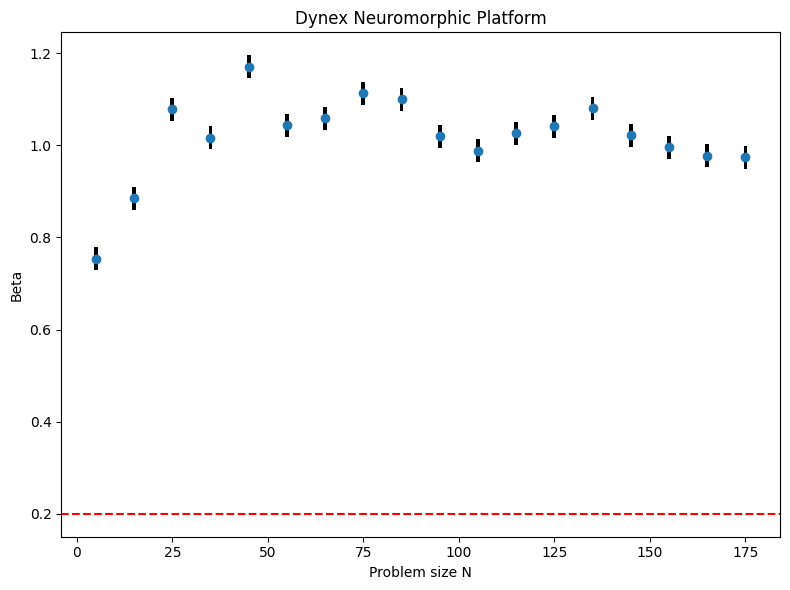

In [64]:
plt.figure(figsize=(8,6))
plt.bar(df.n,0.05, width=1, bottom=df.beta-0.025, color='#000000')
plt.plot(df['n'], df['beta'], linestyle='None', marker='o')
plt.title('Dynex Neuromorphic Platform')
plt.xlabel('Problem size N')
plt.ylabel('Beta')
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 
plt.tight_layout()
plt.show()

## References

[1] Martiel S, Ayral T, Allouche C. Benchmarking quantum coprocessors in an application-centric, hardware-agnostic, and scalable way. IEEE Transactions on Quantum Engineering. 2021 Jun 17;2:1-1.

[2] Atos Package for computing the Atos Q-score: 
https://github.com/myQLM/qscore/blob/master/qat/qscore/https://github.com/myQLM/qscore/blob/master/qat/qscore/